In [1]:
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, mean_absolute_error
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from category_encoders import OneHotEncoder, OrdinalEncoder
from xgboost import XGBClassifier, XGBRegressor
from shap import TreeExplainer, initjs, force_plot
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot

In [2]:
train = pd.read_csv( 'train.csv' , index_col= 'id' )

test = pd.read_csv( 'test.csv' , index_col = 'id' )

In [3]:
train.rename( columns = { 'number_of_total_atoms' : 'tot_atom' , 
                          'percent_atom_al' : 'al_atom_p' ,
                          'percent_atom_ga' : 'ga_atom_p' , 
                          'percent_atom_in' : 'in_atom_p' , 
                          'lattice_vector_1_ang' : 'ang_1' ,
                          'lattice_vector_2_ang' : 'ang_2' , 
                          'lattice_vector_3_ang' : 'and_3' ,
                          'lattice_angle_alpha_degree' : 'angle_a' , 
                          'lattice_angle_beta_degree' : 'angle_b' ,
                          'lattice_angle_gamma_degree' : 'angle_g' ,
                          'formation_energy_ev_natom' : 'f_energy' ,
                          'bandgap_energy_ev' : 'bg_energy' } , inplace = True )

test.rename( columns = { 'number_of_total_atoms' : 'tot_atom' , 
                         'percent_atom_al' : 'al_atom_p' ,
                         'percent_atom_ga' : 'ga_atom_p' , 
                         'percent_atom_in' : 'in_atom_p' , 
                         'lattice_vector_1_ang' : 'ang_1' ,
                         'lattice_vector_2_ang' : 'ang_2' , 
                         'lattice_vector_3_ang' : 'and_3' ,
                         'lattice_angle_alpha_degree' : 'angle_a' , 
                         'lattice_angle_beta_degree' : 'angle_b' ,
                         'lattice_angle_gamma_degree' : 'angle_g' } , inplace = True )

def wrangle(df):

    atoms = [ 'al' , 'ga' , 'in' ]
    
    for elem in atoms:
        df[ f'{ elem }_atoms' ] = df.tot_atom * df[ f'{ elem }_atom_p' ]
    
    df[ 'al_ga_ratio' ] = df.al_atoms / df.ga_atoms
    df[ 'al_in_ratio' ] = df.al_atoms / df.in_atoms
    df[ 'in_ga_ratio' ] = df.in_atoms / df.ga_atoms

    ratios = [ 'al_ga_ratio' , 'al_in_ratio' , 'in_ga_ratio' ]
    nulls = [ np.nan , np.inf ]
    
    for col in ratios:
        df[ col ] = df[ col ].replace( np.inf , np.nan )
        df[ col ] = df[ col ].replace( np.nan , df[ col ].median() )
    
    return df

train = wrangle( train )

test = wrangle( test )

In [4]:
target1 = 'bg_energy'
target2 = 'f_energy'

X = train.drop( columns = [ target1 , target2 ] )
X_test = test

y1 = train[ target1 ]
y2 = train[ target2 ]

In [5]:
X1_train, X1_val, y1_train, y1_val = train_test_split( 
    X , y1 , train_size = 0.9 , random_state = 19 )

X2_train, X2_val, y2_train, y2_val = train_test_split( 
    X , y2 , train_size = 0.9 , random_state = 19 )

y1_pred = [y1_train.mean()] * len(y1_train)
y2_pred = [y2_train.mean()] * len(y2_train)

print('Band Gap Energy')
print('Mean (eV): ', y1_train.mean())
print('Baseline MAE: ' , mean_absolute_error( y1_train , y1_pred ) )
print()
print('Formation Energy')
print('Mean (eV): ', y2_train.mean())
print('Baseline MAE: ' , mean_absolute_error( y2_train , y2_pred ) )

Band Gap Energy
Mean (eV):  2.0804772685185187
Baseline MAE:  0.8267515736025377

Formation Energy
Mean (eV):  0.18696375
Baseline MAE:  0.08535369444444445


In [12]:
ss = StandardScaler()

# rscv =  RandomizedSearchCV()
lr = LinearRegression()
logr = LogisticRegression( random_state = 19 )
xgbr = XGBRegressor( n_estimators = 100 , random_state = 42 )
rfr = RandomForestRegressor( n_estimators = 100 , random_state = 42 )

model_lr = make_pipeline( ss , lr )
model_logr = make_pipeline( ss , logr ) 
model_xgbr = make_pipeline( ss , xgbr )
model_rfr = make_pipeline( ss , rfr )

model_lr1 = model_lr.fit( X1_train , y1_train );
model_xgbr1 = model_xgbr.fit( X1_train , y1_train );
model_rfr1 = model_rfr.fit( X1_train , y1_train );

model_lr2 = model_lr.fit( X2_train , y2_train );
model_xgbr2 = model_xgbr.fit( X2_train , y2_train );
model_rfr2 = model_rfr.fit( X2_train , y2_train );

In [15]:
print('Linear Regression')
print('BandGap train MAE: ' , round( mean_absolute_error( 
                                     y1_train , model_lr1.predict( X1_train ) ) , 3 ) )
print('BandGap val MAE: ' , round( mean_absolute_error( 
                                   y1_val , model_lr1.predict( X1_val ) ) , 3 ) )
print()
print('Formaion train MAE: ' , round( mean_absolute_error( 
                                      y2_train , model_lr2.predict( X2_train ) ) , 3 ) )
print('Formation val MAE: ' , round( mean_absolute_error( 
                                     y2_val , model_lr2.predict( X2_val ) ) , 3 ) )
print()

print('Random Forest Regressor')
print('BandGap train MAE: ' , round( mean_absolute_error( 
                                     y1_train , model_rfr1.predict( X1_train ) ) , 3 ) )
print('BandGap val MAE: ' , round( mean_absolute_error( 
                                   y1_val , model_rfr1.predict( X1_val ) ) , 3 ) )
print()
print('Formaion train MAE: ' , round( mean_absolute_error( 
                                      y2_train , model_rfr2.predict( X2_train ) ) , 3 ) )
print('Formation val MAE: ' , round( mean_absolute_error( 
                                     y2_val , model_rfr2.predict( X2_val ) ) , 3 ) )
print()

print('XGBRegressor')
print('BandGap train MAE: ' , round( mean_absolute_error( 
                                     y1_train , model_xgbr1.predict( X1_train ) ) , 3 ) )
print('BandGap val MAE: ' , round( mean_absolute_error( 
                                   y1_val , model_xgbr1.predict( X1_val ) ) , 3 ) )
print()
print('Formaion train MAE: ' , round( mean_absolute_error( 
                                      y2_train , model_xgbr2.predict( X2_train ) ) , 3 ) )
print('Formation val MAE: ' , round( mean_absolute_error( 
                                     y2_val , model_xgbr2.predict( X2_val ) ) , 3 ) )

Linear Regression
BandGap train MAE:  1.895
BandGap val MAE:  1.859

Formaion train MAE:  0.059
Formation val MAE:  0.058

Random Forest Regressor
BandGap train MAE:  1.896
BandGap val MAE:  1.859

Formaion train MAE:  0.015
Formation val MAE:  0.027

XGBRegressor
BandGap train MAE:  1.896
BandGap val MAE:  1.859

Formaion train MAE:  0.013
Formation val MAE:  0.029


In [70]:
# dic = { 'target' : [ 'Band Gap' , 'Formation' ] ,
#          'modna' : [ 'LR' , 'RFR' , 'XGBR' ] ,
#          'bgmod' : [ model_lr1 , model_rfr1 , model_xgbr1 ] ,
#          'fmod' : [ model_lr2 , model_rfr2 , model_xgbr2 ] }

# for n in dic['bgmod']:
#     print( dic[target][0] , ' training MAE: ' , mean_absolute_error( 
#                                                 y1_train , model.predict( X1_train ) ) )
#     print( dic[target][0] , ' validation MAE: ' , mean_absolute_error( 
#                                                   y1_val , model.predict( X1_val ) ) )

KeyError: 'bg_energy'

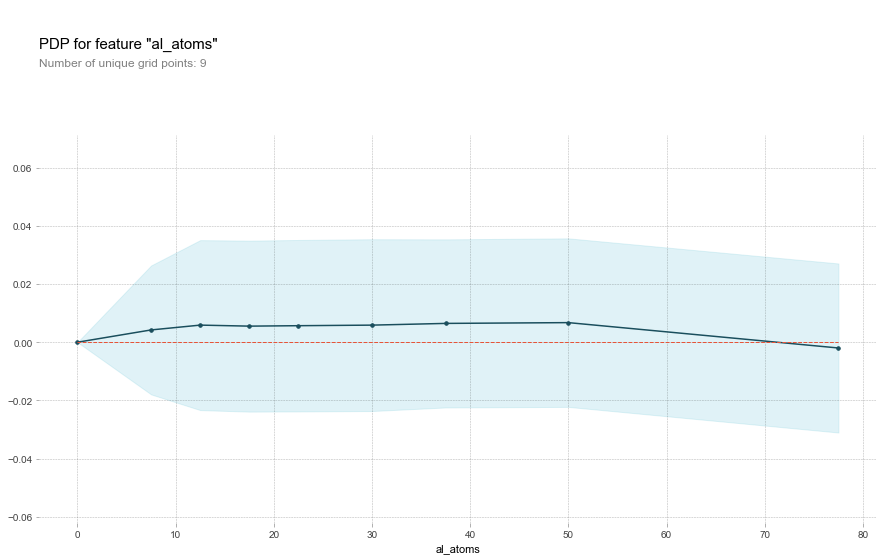

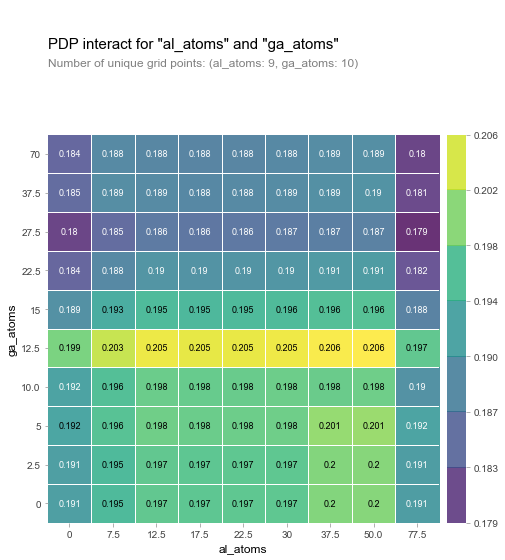

In [18]:
feature = 'al_atoms'
features = ['al_atoms', 'ga_atoms']

isolate1 = pdp_isolate( model = model_xgbr1 ,
                       dataset = X1_val ,
                       model_features = X1_val.columns ,
                       feature = feature )
pdp_plot( isolate1, feature_name = feature );

interact1 = pdp_interact( model = model_xgbr1 ,
                         dataset = X1_val ,
                         model_features = X1_val.columns ,
                         features = features )
pdp_interact_plot( interact1 , plot_type = 'grid' , feature_names = features );

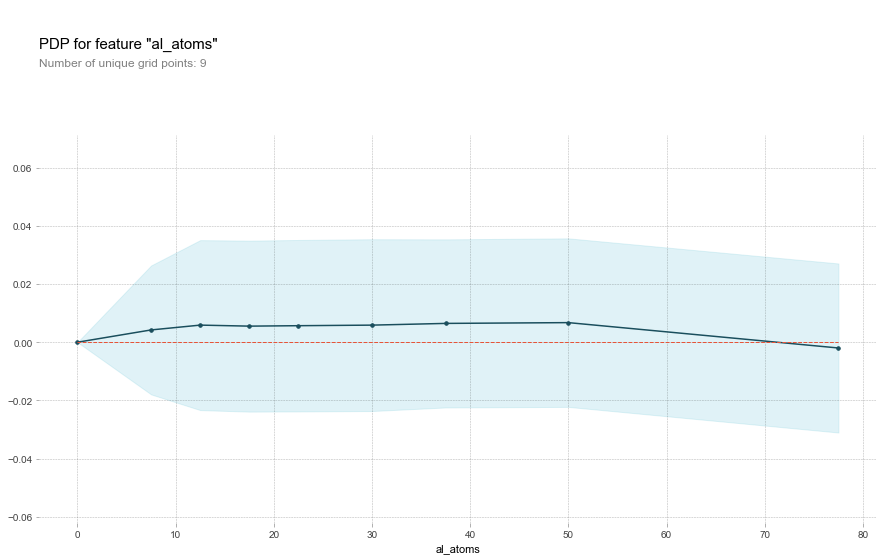

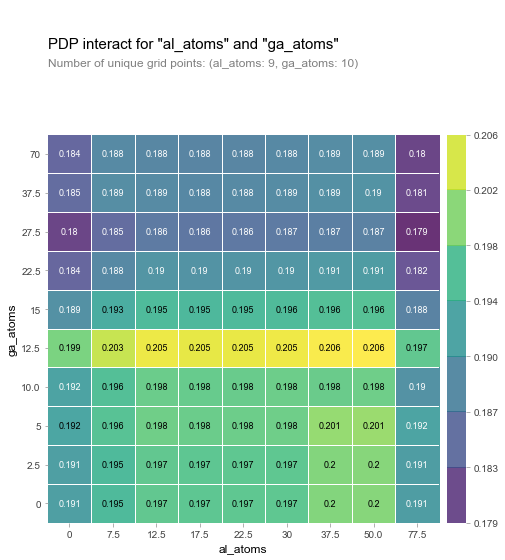

In [20]:
isolate2 = pdp_isolate( model = model_xgbr2 ,
                       dataset = X2_val ,
                       model_features = X2_val.columns ,
                       feature = feature )
pdp_plot( isolate2 , feature_name = feature );

interact2 = pdp_interact( model = model_xgbr2 ,
                         dataset = X2_val ,
                         model_features = X2_val.columns ,
                         features = features )
pdp_interact_plot( interact2 , plot_type = 'grid' , feature_names = features );